# Predicting Newsletter Subscription in Video Game Research Server
dsci100_033 group final project report

Egshiglen Erdembayar, Yunan Deng, Guo Chen, Samuel Yu

## Introduction

### Background information

Professor Frank Wood and his team at UBC built a Minecraft server that records player actions. Minecraft is a popular open-world game and players can move and interact on the server. The group project is called PLAICraft, which collects real gameplay data to understand player behavior and answer research questions. However, the team faces lots of challenges in the real world, such as how to recruit players, how to predict player numbers, and how to manage server resources. Therefore, our group uses the real data they provided to build a predictive model to answer one of their research questions. In this project report we study whether a player's total hours played and age can predict whether they subscribe to the newsletter.

- The broad question： What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?
  
- The specific question: Does the player's total hours played and age predict whether they subscribe to the newsletter? 

### Data summary
The players.csv dataset contains information about individual players on the Minecraft server. The dataset contains 6 variables: experience, subscribe, played_hours, name, hashedEmail and Age. This dataset contains 196 players because 1 observation represents 1 player. It is appropriate for answering our specific research quetion because it directly provides both the predictors (Age and played_hours) and the response variable (subscribe).

### Load data

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(lubridate)
library(RColorBrewer)
library(yardstick)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read_csv("https://raw.githubusercontent.com/yunan-Deng/data_science_100_group33/refs/heads/main/players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


The question that we have chosen to explore is: Does the player's total hours played and age predict whether they subscribe to the newsletter? Although given data from both the players and the sessions they played, we will only be using data from **players.csv** to answer the question.

For `players.csv`, there are a total of 196 observations and 7 columns (variables), which include:
- `experience (chr)`: The player's skill level (Beginner, Amateur, Regular, Veteran, Pro)
- `subscribe (lgl)`: Whether the player has an active subscription (TRUE = active, FALSE = inactive)
- `hashedEmail (chr)`: Encrypted email for security and privacy
- `played_hours (dbl)`: The number of hours the player has spent on the game
- `name (chr)`: The name of the player
- `gender (chr)`: The gender of the player
- `Age (dbl)`: The age of the player

For our specific question, the data is already clean, and so no tidying is needed. However, some wrangling must be done.

In [3]:
players <- players |>
    mutate(subscribe = as.factor(subscribe),
          experience = as.factor(experience))
players_clean <- players |>
    select(experience, subscribe, played_hours, Age)
head(players_clean)

experience,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
Pro,TRUE,30.3,9
Veteran,TRUE,3.8,17
Veteran,FALSE,0.0,17
Amateur,TRUE,0.7,21
Regular,TRUE,0.1,21
Amateur,TRUE,0.0,17


In [4]:
subscriber_count <- players_clean |>
    summarize(subscribed = sum(subscribe == TRUE, na.rm = TRUE), unsuscribed = sum(subscribe == FALSE, na.rm = TRUE))
subscriber_count


subscribed,unsuscribed
<int>,<int>
144,52


In [5]:
players_summary <- players_clean |>
    summarize(avg_hours = mean(played_hours, na.rm = TRUE), avg_age = mean(Age, na.rm = TRUE))
players_summary

avg_hours,avg_age
<dbl>,<dbl>
5.845918,21.13918


 ### Cleaning Summary
 First, we converted **subscribe** and **experience** into categorical variables. Then, we used the **select** function to pick the key columns for analysis, including **subscribe**, **experience**, **played_hours**, **Age**. We handled the missing values and summarized the subscription status of the players. From the code and tibble, we can find that 144 players subscribed to the newsletter and 52 players did not. The average played hours is about 5.85 hours ,and the average age is about 21 years. All of the data we collect and the cleaning steps provided are to ensure the data is ready for analysis and modelling.

We can next take a look at how each factor, `played_hours` and `Age`, might help in us being able to predict whether a player is subscribed to the newsletter.

Looking at hours played:

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


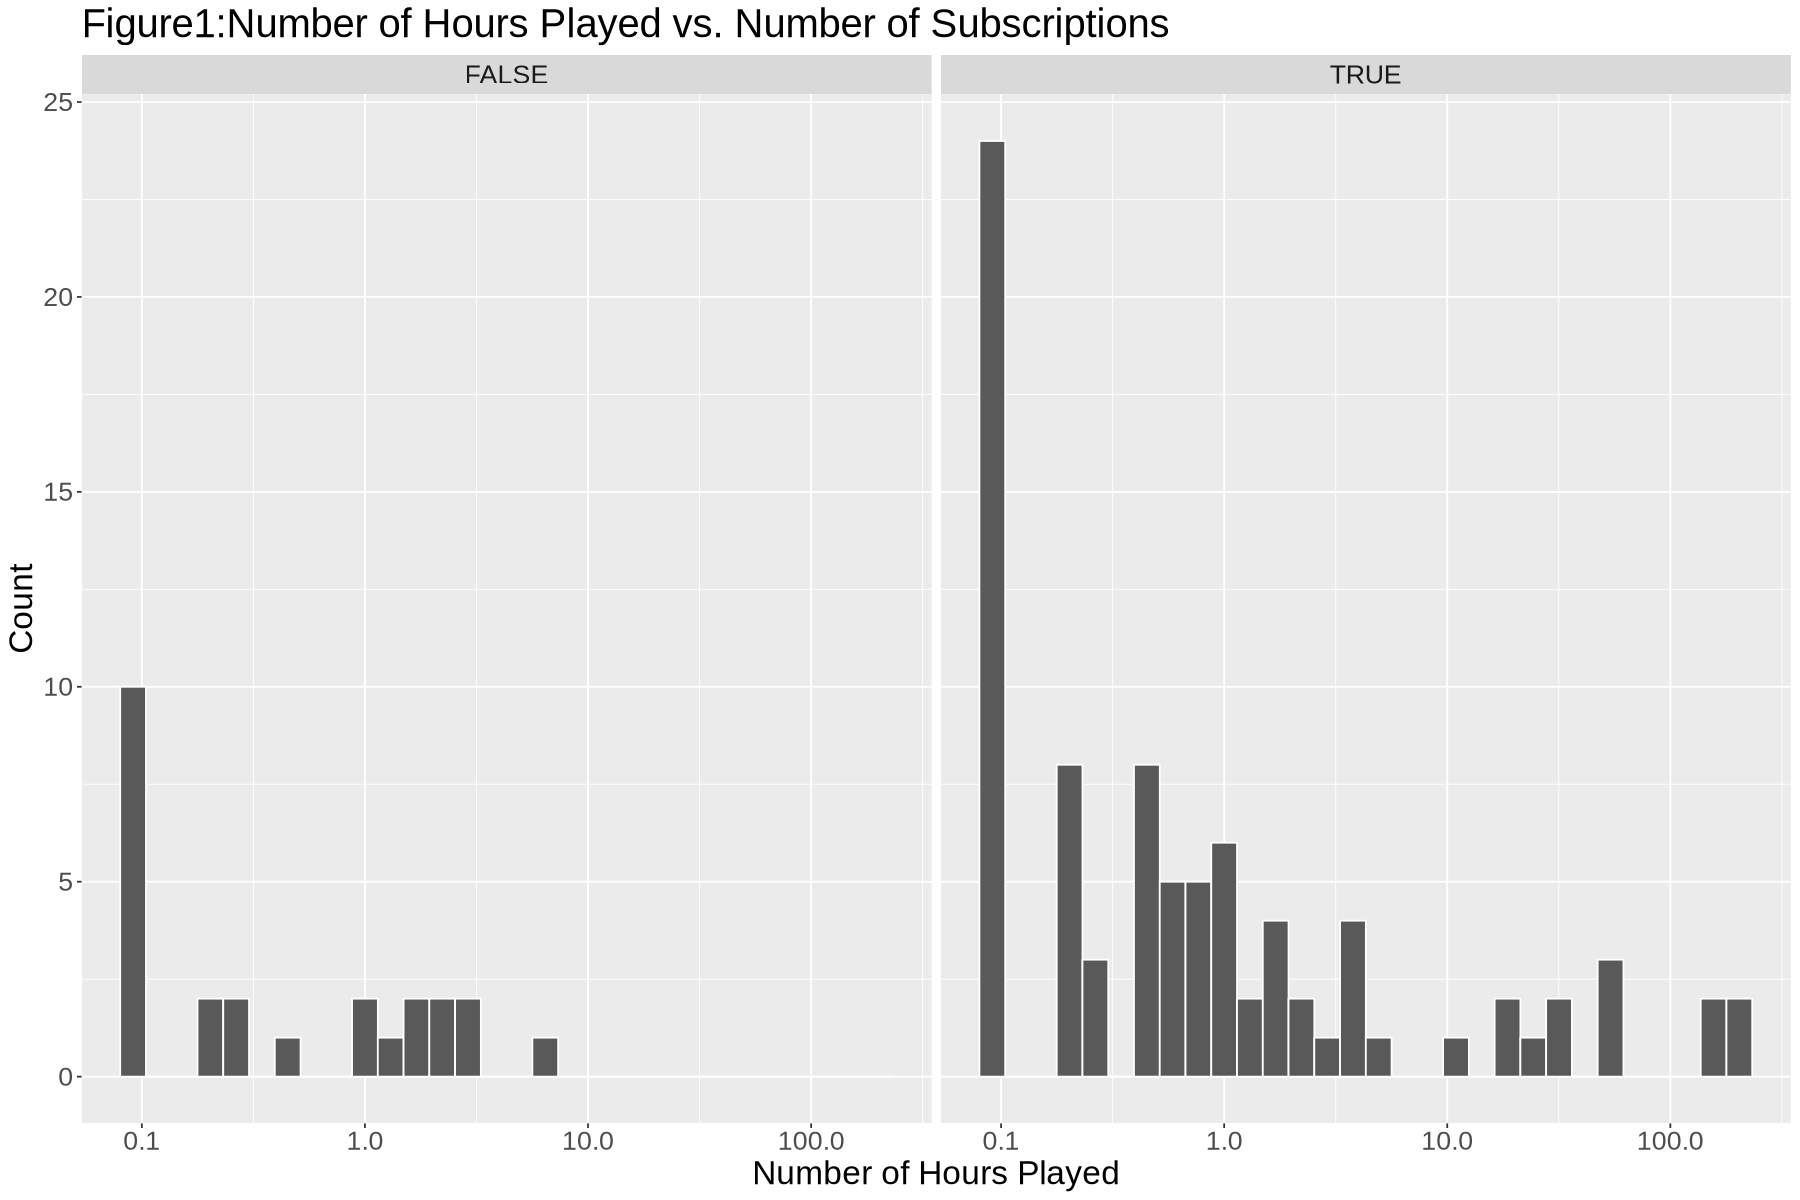

In [6]:
options(repr.plot.width = 15, repr.plot.height = 10)
players_hours <- players_clean |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(bins = 30, color = "white") +
    scale_x_log10() +
    facet_wrap(~subscribe) +
    labs(title = "Figure1:Number of Hours Played vs. Number of Subscriptions", x = "Number of Hours Played", y = "Count") +
    theme(text = element_text(size = 20))
players_hours

Figure 1 description. We see that people with more hours played are more likely to be subscribed, but it is a rather weak relationship, as a large majority of players subscribed also have a lower amount of hours played.

Looking at player age:

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


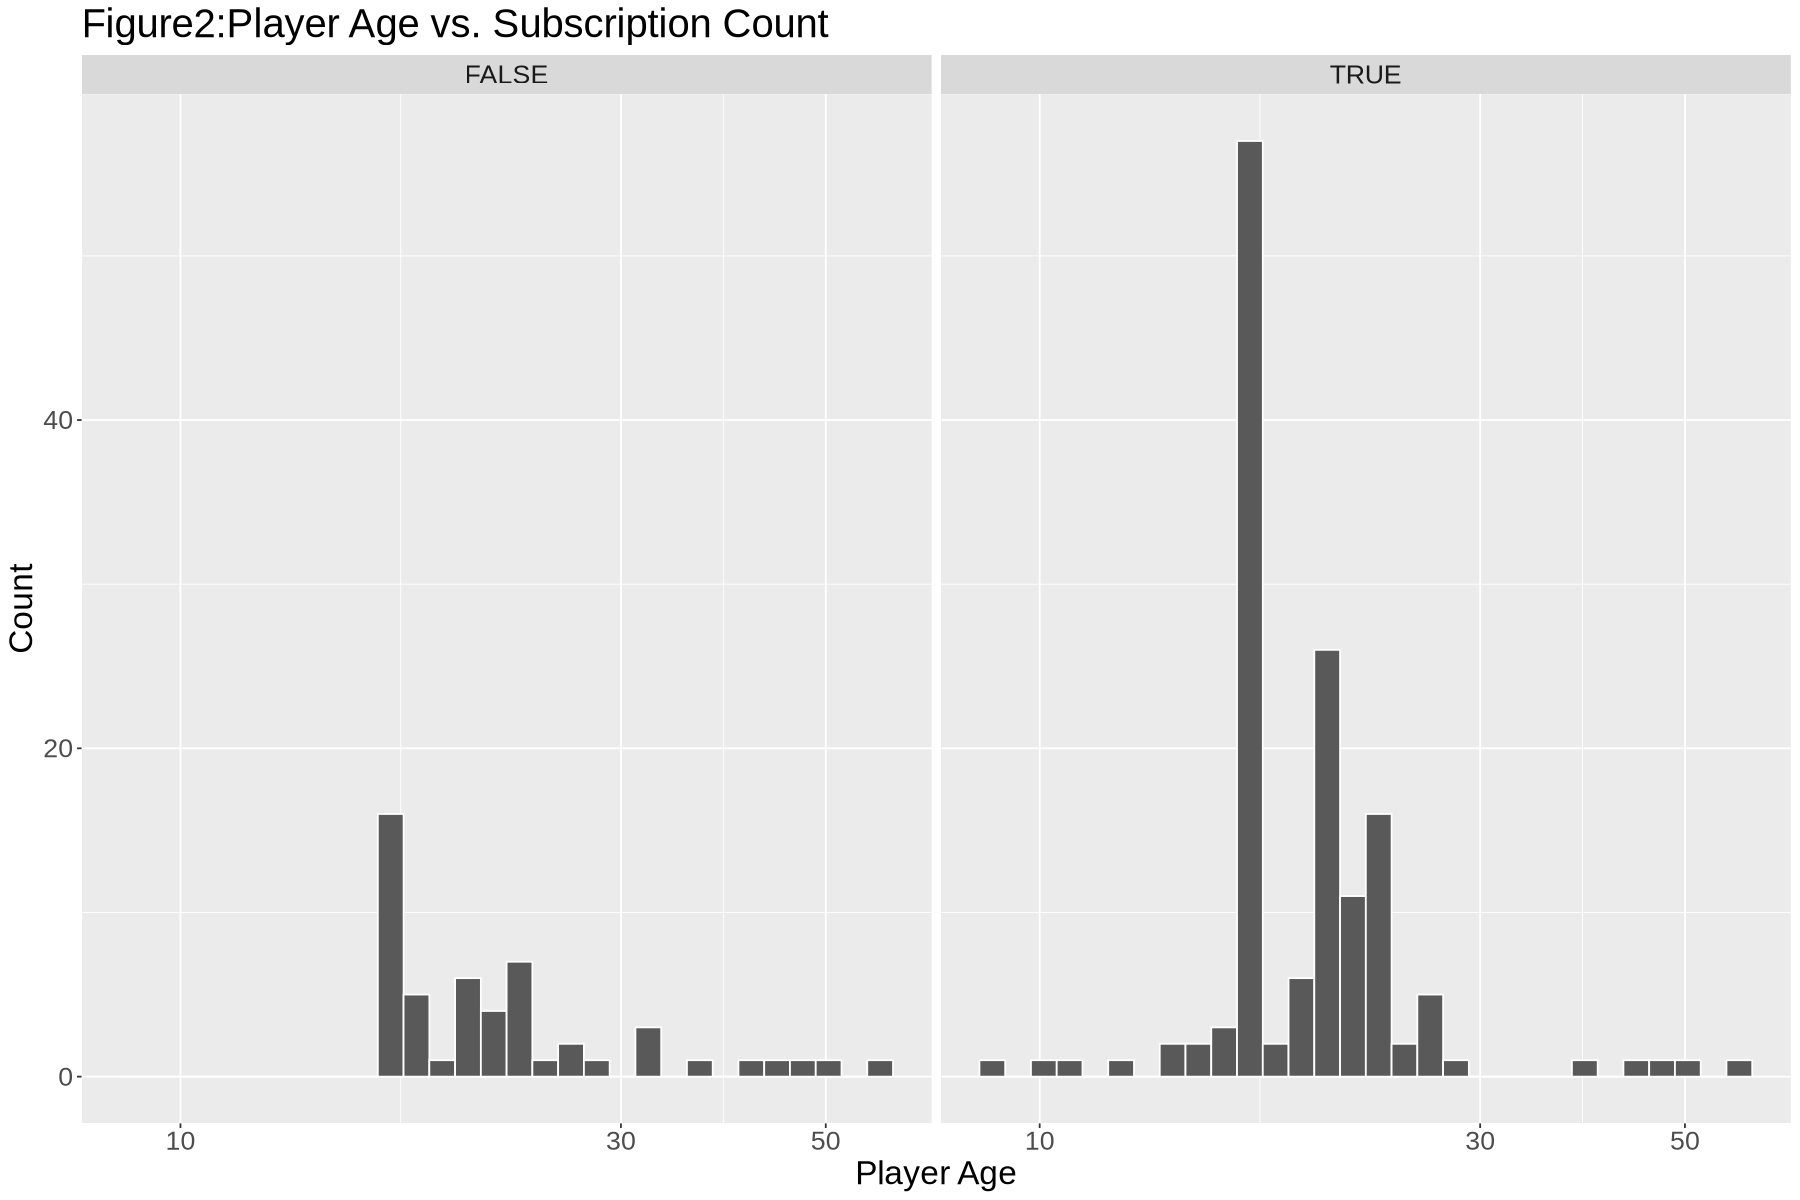

In [7]:
options(repr.plot.width = 15, repr.plot.height = 10)
players_age <- players_clean |>
    ggplot(aes(x = Age)) +
    geom_histogram(bins = 30, color = "white") +
    scale_x_log10() +
    facet_wrap(~subscribe) +
    labs(title = "Figure2:Player Age vs. Subscription Count", x = "Player Age", y = "Count") +
    theme(text = element_text(size = 20))
players_age

Figure2 description. We see that there seems to be a correlation between the player's age and number of people subscibed. We see that the majority of players are around 15 to 30 years old, with a huge peak in players that are subscribed at around 15 years old. However, this is a weak relationship, as we see there is a similar relationship between players that are subscribed and players that are not subscribed for most of the ages.

We can visualize the relationships using a scatterplot:

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


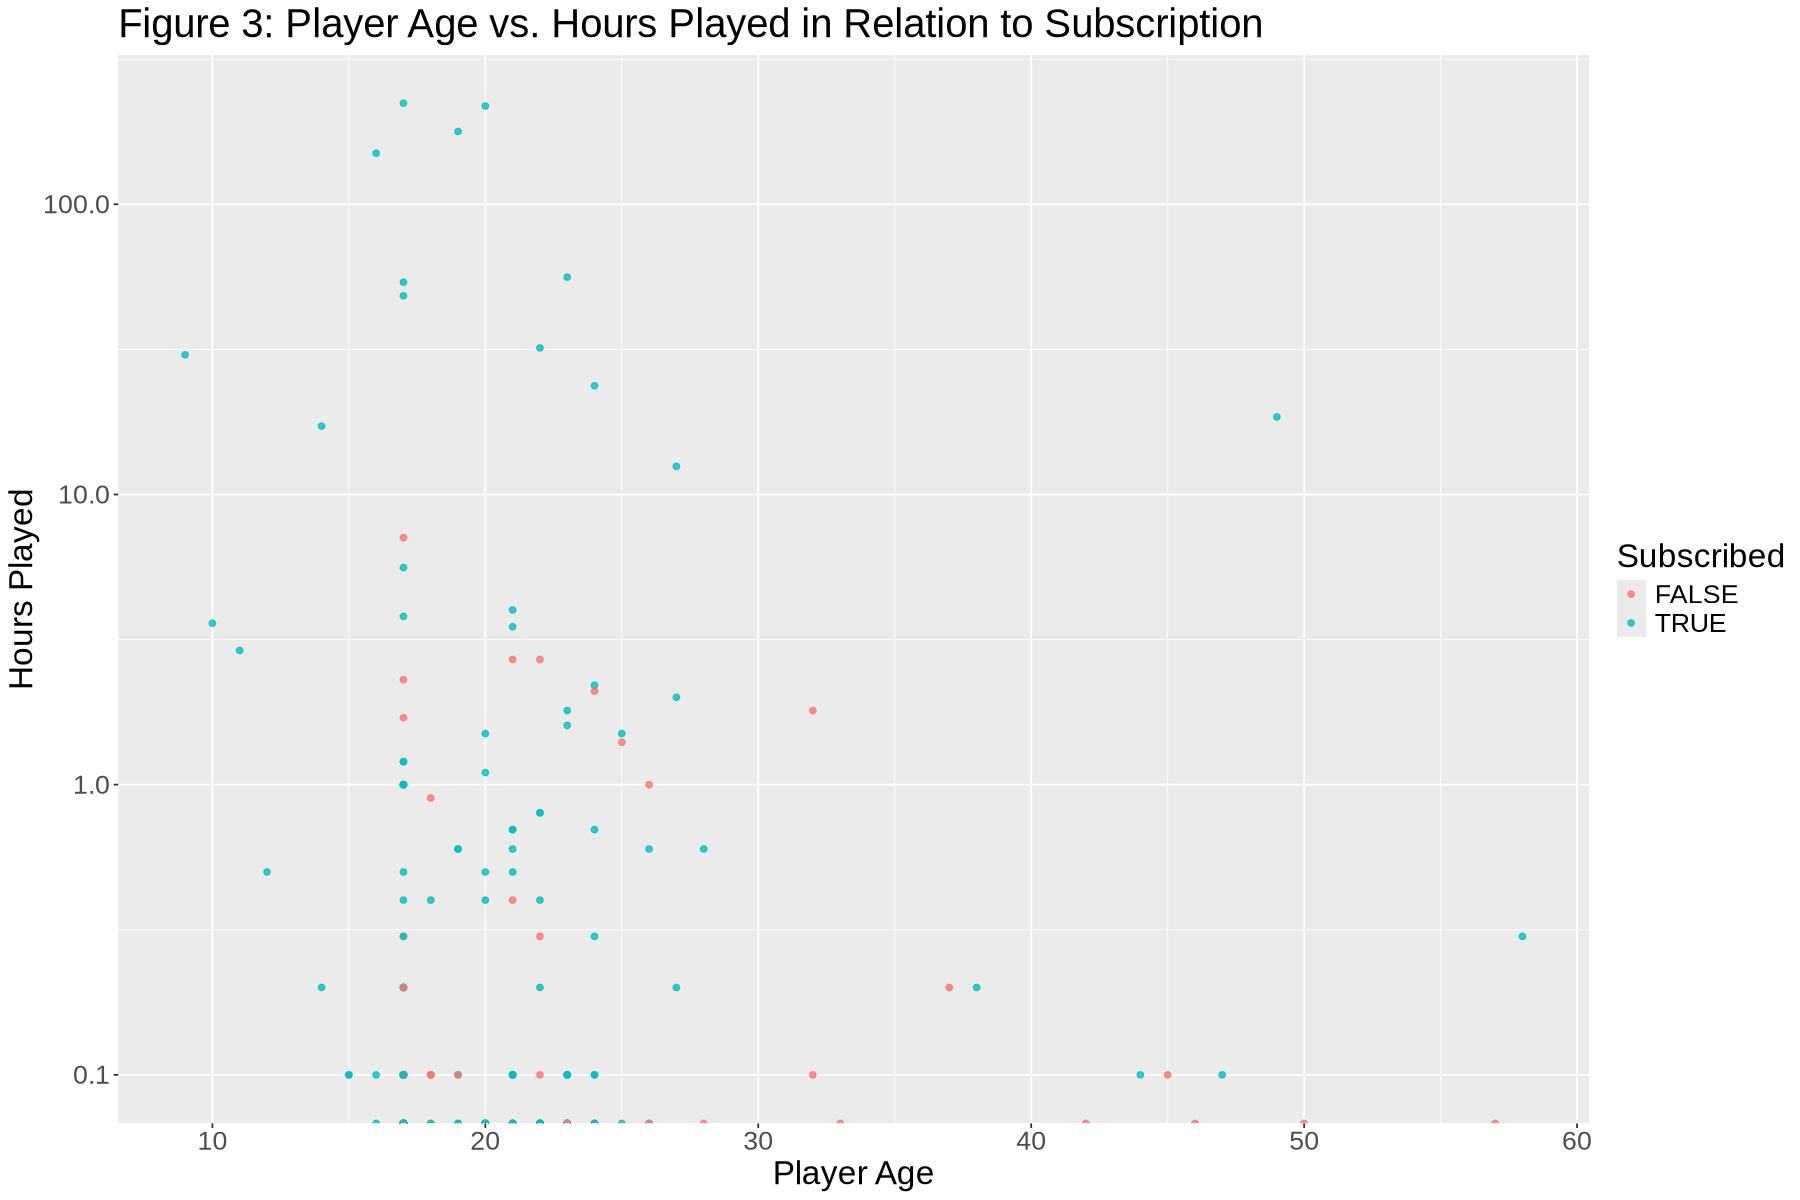

In [8]:
players_relationship <- players_clean |>
    ggplot(aes(x = Age, y = played_hours, colour = subscribe)) +
    geom_point(alpha = 0.8) +
    scale_y_log10() +
    labs(title = "Figure 3: Player Age vs. Hours Played in Relation to Subscription", x = "Player Age", y = "Hours Played", colour = "Subscribed") +
    theme(text = element_text(size = 20))
players_relationship

Figure 3 description. Although not a strong relationship, there are a lot more players around the 15 to 30 age range that have a higher amount of hours played that are subscribed. However, there are many more players that have a lower amount of hours played, which may skew results.

## KNN Classification Modeling

Since the outcome variable (newsletter subscription) is binary, this problem will formulate as a classification task. We will use KNN Classfication to model the answer of questions.

Before we modeling the data, we need to check the missing data in our data set and consider what methods should we use, drop them or impute the missing entries.

In [9]:
players_NAinfo <- players_clean |>
  filter(if_any(everything(), is.na))
players_NAinfo 

experience,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
Regular,TRUE,0.1,NA
Pro,TRUE,0.2,NA


Fortunately, we only have 2 missing data in the data set of players, 2 of 196 is not very important.
So we will use drop_na() function to solve the missing data.

In [10]:
player_modeldata <- players_clean |>
  select(subscribe, played_hours,Age)|> drop_na()
player_modeldata

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
⋮,⋮,⋮
FALSE,0.3,22
FALSE,0.0,57
FALSE,2.3,17


In [11]:
set.seed(123)
players_split <- initial_split(player_modeldata, prop = 0.8,strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

In [12]:
#recipe
players_recipe <- recipe(subscribe ~ played_hours + Age, data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) 
players_recipe 



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [13]:
#Model setup: 
players_spec <- nearest_neighbor(mode = "classification",
                                 neighbors = tune()) |>
                                 set_engine("kknn") 

players_workflow <- workflow()|>
  add_model(players_spec)|>
  add_recipe(players_recipe)

#Set up tuning grid for k
players_grid <- tibble(neighbors = seq(from = 1, to = 15, by = 2))

#Create cross-validation folds
set.seed(123)
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

In [14]:
#Model training: 
players_results <- players_workflow |>
    tune_grid(resamples = players_vfold ,
              grid = players_grid,
              metrics = metric_set(accuracy))

players_metrics <- collect_metrics(players_results)
players_metrics

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4604435,5,0.02420314,Preprocessor1_Model1
3,accuracy,binary,0.4671102,5,0.02323508,Preprocessor1_Model2
5,accuracy,binary,0.4997984,5,0.02453929,Preprocessor1_Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,binary,0.6496909,5,0.04853682,Preprocessor1_Model6
13,accuracy,binary,0.6561425,5,0.05191348,Preprocessor1_Model7
15,accuracy,binary,0.6765726,5,0.03984151,Preprocessor1_Model8


In [15]:
# choose best k
best_k <- players_results |>
  select_best("accuracy") 
best_k

neighbors,.config
<dbl>,<chr>
15,Preprocessor1_Model8


In [16]:
#fit into test data
final_knn <- finalize_workflow(players_workflow , best_k)

final_fit <- final_knn |>
  fit(data = players_train)

In [17]:
# see the final result
predictions <- predict(final_fit, new_data = players_test) |>
  bind_cols(players_test)

head(predictions)

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
TRUE,TRUE,3.8,17
FALSE,FALSE,0.0,17
TRUE,FALSE,0.0,21
TRUE,TRUE,48.4,17
FALSE,TRUE,0.3,58
FALSE,FALSE,0.1,18


### 1.Why KNN fits the question? 
`--Does the player's total hours played and age predict whether they subscribe to the newsletter? `

KNN (k-Nearest Neighbors) is suitable for this problem because the task is to predict whether a player subscribes to the newsletter (a categorical outcome: TRUE/FALSE) based on numerical features like played_hours and Age.

It does not need to assume function relationship between the predictors and the outcome.

Since we only have a few predictors and a moderate-sized dataset, KNN can efficiently leverage the distance information to classify new players based on their nearest neighbors.


### 2.Why standardization is necessary

Standardization is crucial because KNN relies on distance calculations (typically Euclidean distance) to find nearest neighbors.

Features like played_hours and Age are on different scales (played_hours might range 0–50, while Age ranges 0–60).

Without standardization, features with larger ranges dominate the distance computation, causing the model to ignore smaller-scale features, which can bias predictions.

By standardizing all numeric predictors to have mean 0 and standard deviation 1, each feature contributes equally to the distance, ensuring fair comparison between observations.

### 3.How K was chosen
The optimal number of neighbors 
𝑘
k was chosen through cross-validation on the training set:

A grid of possible k values was defined (e.g., 1, 3, 5, 7, 9, 11).

For each candidate k, the model was trained on multiple v-fold cross-validation splits of the training data.

The accuracy of each k was averaged across folds.

The k with the highest average accuracy was selected as the final parameter.

This method ensures that the chosen k balances bias and variance:

Too small k → model may overfit (high variance)

Too large k → model may oversmooth (high bias)

### Modelling steps summary
We formulated the prediction of newsletter subscription as a classification problem. The model we used was K-Nearest Neighbours (KNN), with played_hours and Age as predictors. The dataset was split into 80% for training and 20% for testing, stratifies by subscription status. We are moving two missing values and standardized to ensure fair distance and convincing calculations for KNN. k is selected through 5-fold cross validation in the training set and testing k values from 1 to 15, and chosing one with the highest average accuracy. We use KNN because our response variable is suitable for binary classification.

### Accuracy vs k-Plot
To understand how the number of neighbors influences the performance of our KNN model, we plotted test accuracy across a range of k values. Since KNN's flexibility depends directly on the value of k, examining this plot helps us see whether the model becomes more accuracte, less accurate, or remains stable as k changes. This allows us to determine whether tuning k meaningfully improves performance, or whether the predictors themselves limit the model's accuracy

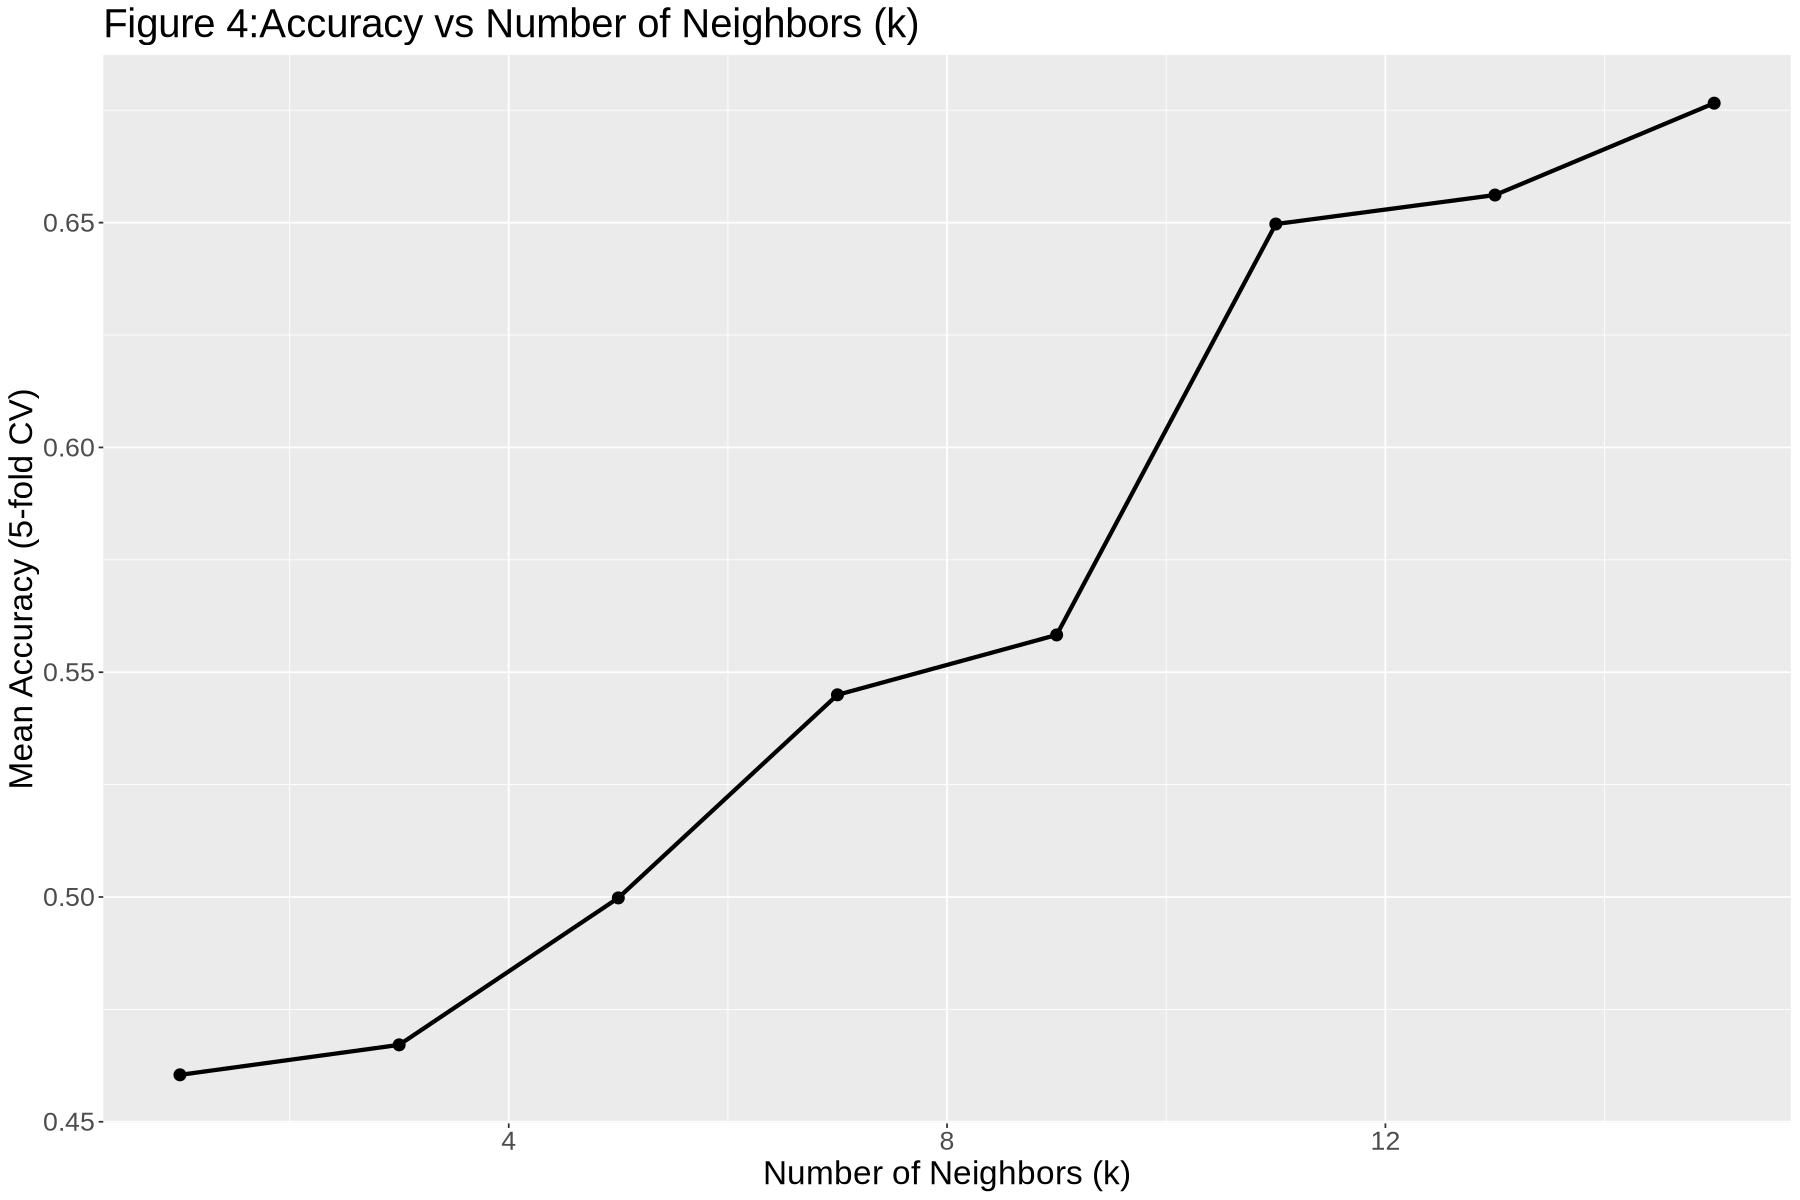

In [18]:
acc_vs_k <- players_metrics |>
filter(.metric == "accuracy") |>
ggplot(aes(x = neighbors, y = mean)) +
geom_line(linewidth = 1.2) +
geom_point(size = 3) +
labs(title = "Figure 4:Accuracy vs Number of Neighbors (k)",
     x = "Number of Neighbors (k)",
     y = "Mean Accuracy (5-fold CV)") +
theme(text = element_text(size = 20))
acc_vs_k

Figure 4 description. We can see that **accuracy** steadily **increases** as **k increases**.
- At **small values** of k (1-5), **accuracy** is **low** around **0.45-0.50**.
- As **k increases** (7-11), **accuracy** climbs to **0.55-0.60**.
- At the highest tested ks(13 and 15), accuracy peaks around 0.67-0.68.
This rising trend suggests that larger k values generalize better for this dataset.

The predictors (Age and played_hours) do not strongly separate subscribers vs non-subscribers, so the model performs better when it averages across more neighbors. When accuracy improves as k increases, it implies that the model was being too sensitive to individual points when k was small. When k is increased, the model considers more neighbors and effectively averages out the effect of noisy points.

Even at its best (~0.67), the model is not very accurate, which shows that just knowing a person's age and hours played is not enough to reliably predict whether they are a subscriber.


### Confusion Matrix

We are using a **confusion matrix** to give us a detailed summary of how well our **classification model** performs on the test data. While **accuracy** only tells us the overall proportion of correct predictions, it does not show what kinds of mistakes the model is making. This is especially important, because predicting subscribers incorrectly can mean different things. For example, falsely predicitng a subscription could waste marketing resources, while missing a true subscriber could mean lost potential engagement. A confusion matrix breaks our results into four categories: **true positives, true negatives, false positives and false negatives**.

In [19]:
conf_mat_res <- conf_mat(predictions,
                         truth = subscribe,
                         estimate = .pred_class)
conf_mat_res

          Truth
Prediction FALSE TRUE
     FALSE     5    6
     TRUE      6   23

**True negatives = 5:**
The model correctly predicted **FALSE** when the actual value was **FALSE**

**False negatives = 6:**
The model predicted **FALSE** when the true value was actually **TRUE**

**False positives = 6:**
The model predicted **TRUE** when the truth was **FALSE**

**True positives = 23:**
The model correctly predicted **TRUE** when the truth was **TRUE**

In [20]:
metrics_tbl <- tibble(accuracy = 0.70,
                      precision = 0.79,
                      recall = 0.79)
metrics_tbl      

accuracy,precision,recall
<dbl>,<dbl>,<dbl>
0.7,0.79,0.79


**Accuracy:** The model correctly classified 70% of players as either subscribers or non-subscribers. This is a moderate performance, not too high but better than random guessing.

**Precision:** 79% of players predicted to subscribe actually did subscribe. This tells us that the model is good at avoiding false positives.

**Recall:** The model captures 79% of true subscribers. This means the model is good at finding the most actual subscribers with relatively few false negatives.

Overall, these values show that the model performs reasonably well, especially for predicting subscribers (TRUE). Lets make a bar plot to visualize this.

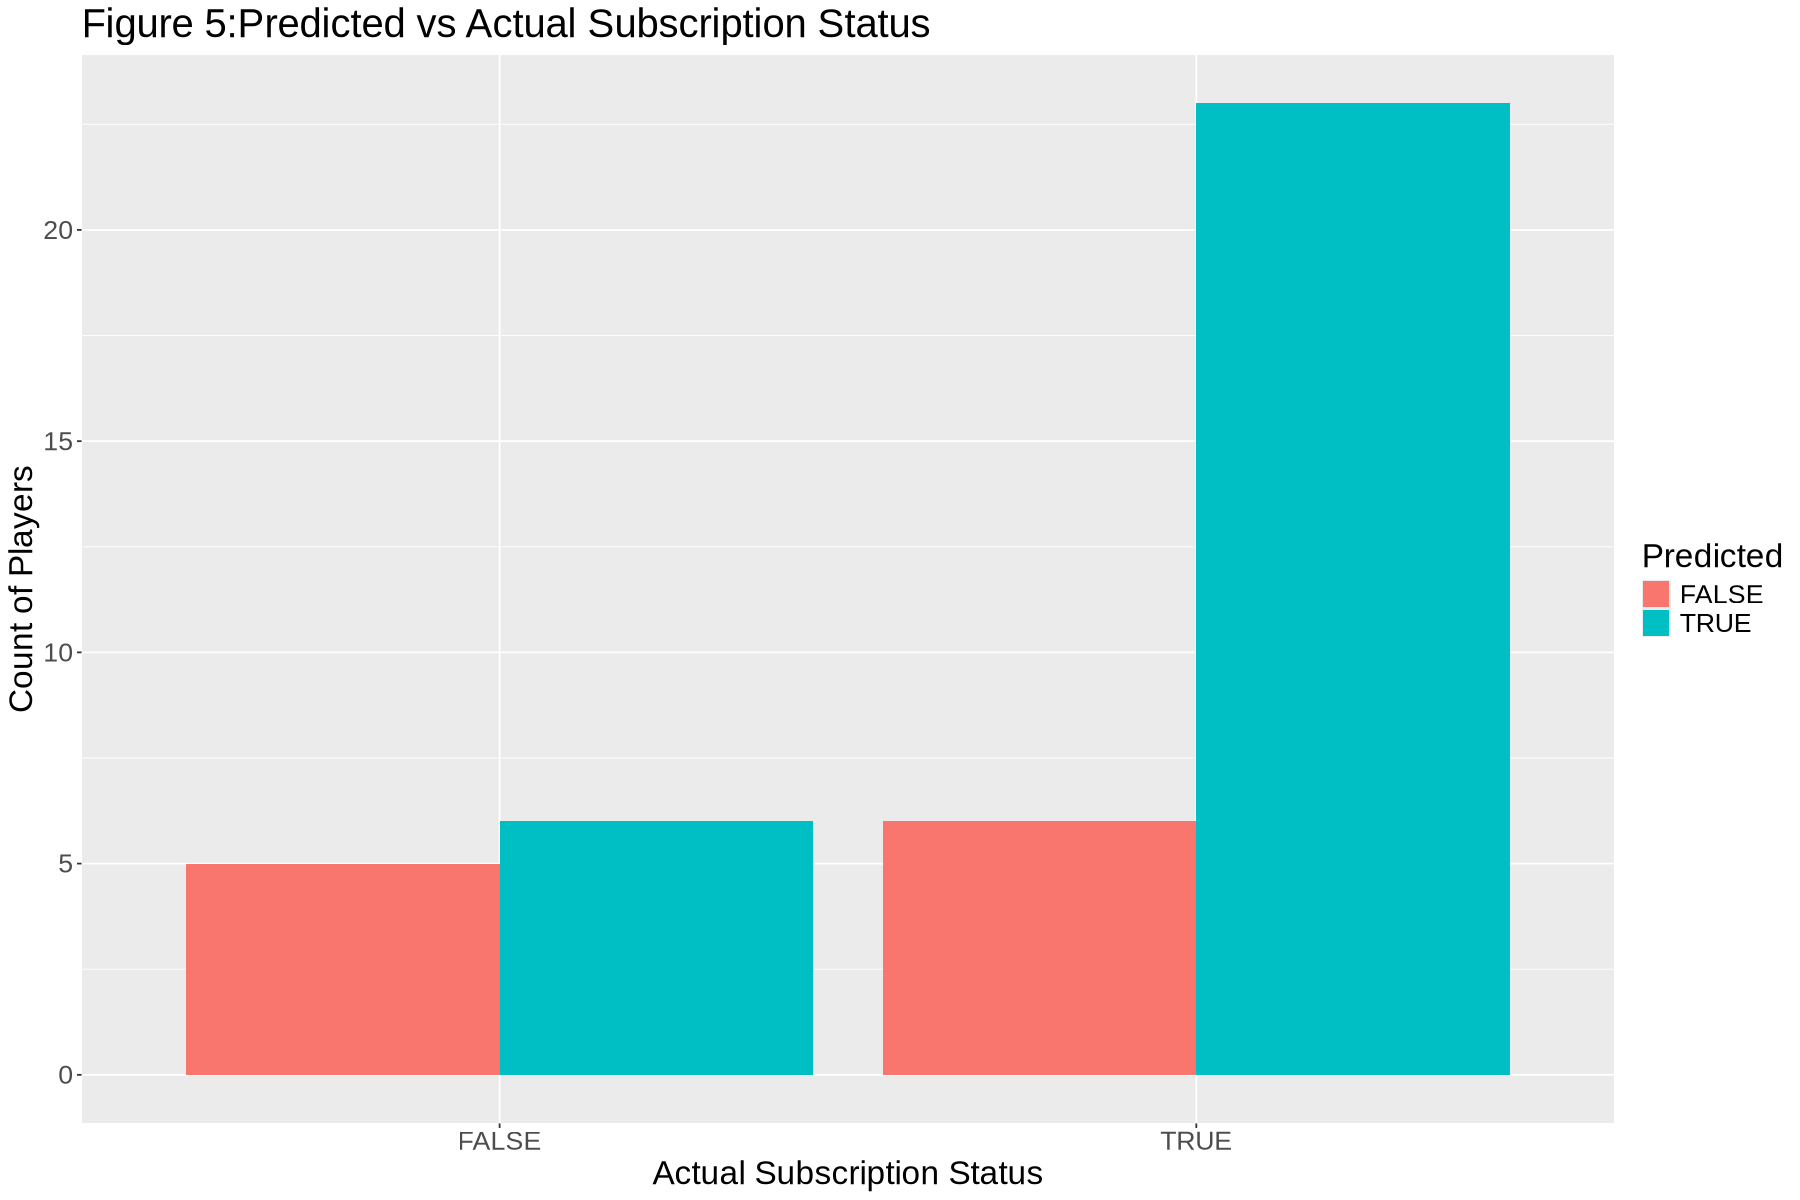

In [21]:
options(repr.plot.width = 15, repr.plot.height = 10)
bar_plot_pred <- predictions |>
ggplot(aes(x = subscribe, fill = .pred_class)) + 
geom_bar(position = "dodge") +
labs(title = "Figure 5:Predicted vs Actual Subscription Status",
     x = "Actual Subscription Status",
     y = "Count of Players",
     fill = "Predicted") +
theme(text = element_text(size = 20))
bar_plot_pred

Figure 5. The model is good at identifying players who actually subscribe, but it often **misclassifies** non-subscribers as subscribers. Overall, it leans toward predicting **TRUE**, showing strong recall for subscribers but **weaker** performance on correctly detecting **non-subscribers**. This may be due to **class imbalance** as the model might achieve decent **accuracy** just by predicting the **majority class**. So lets see if subscribers are the majority of our players.

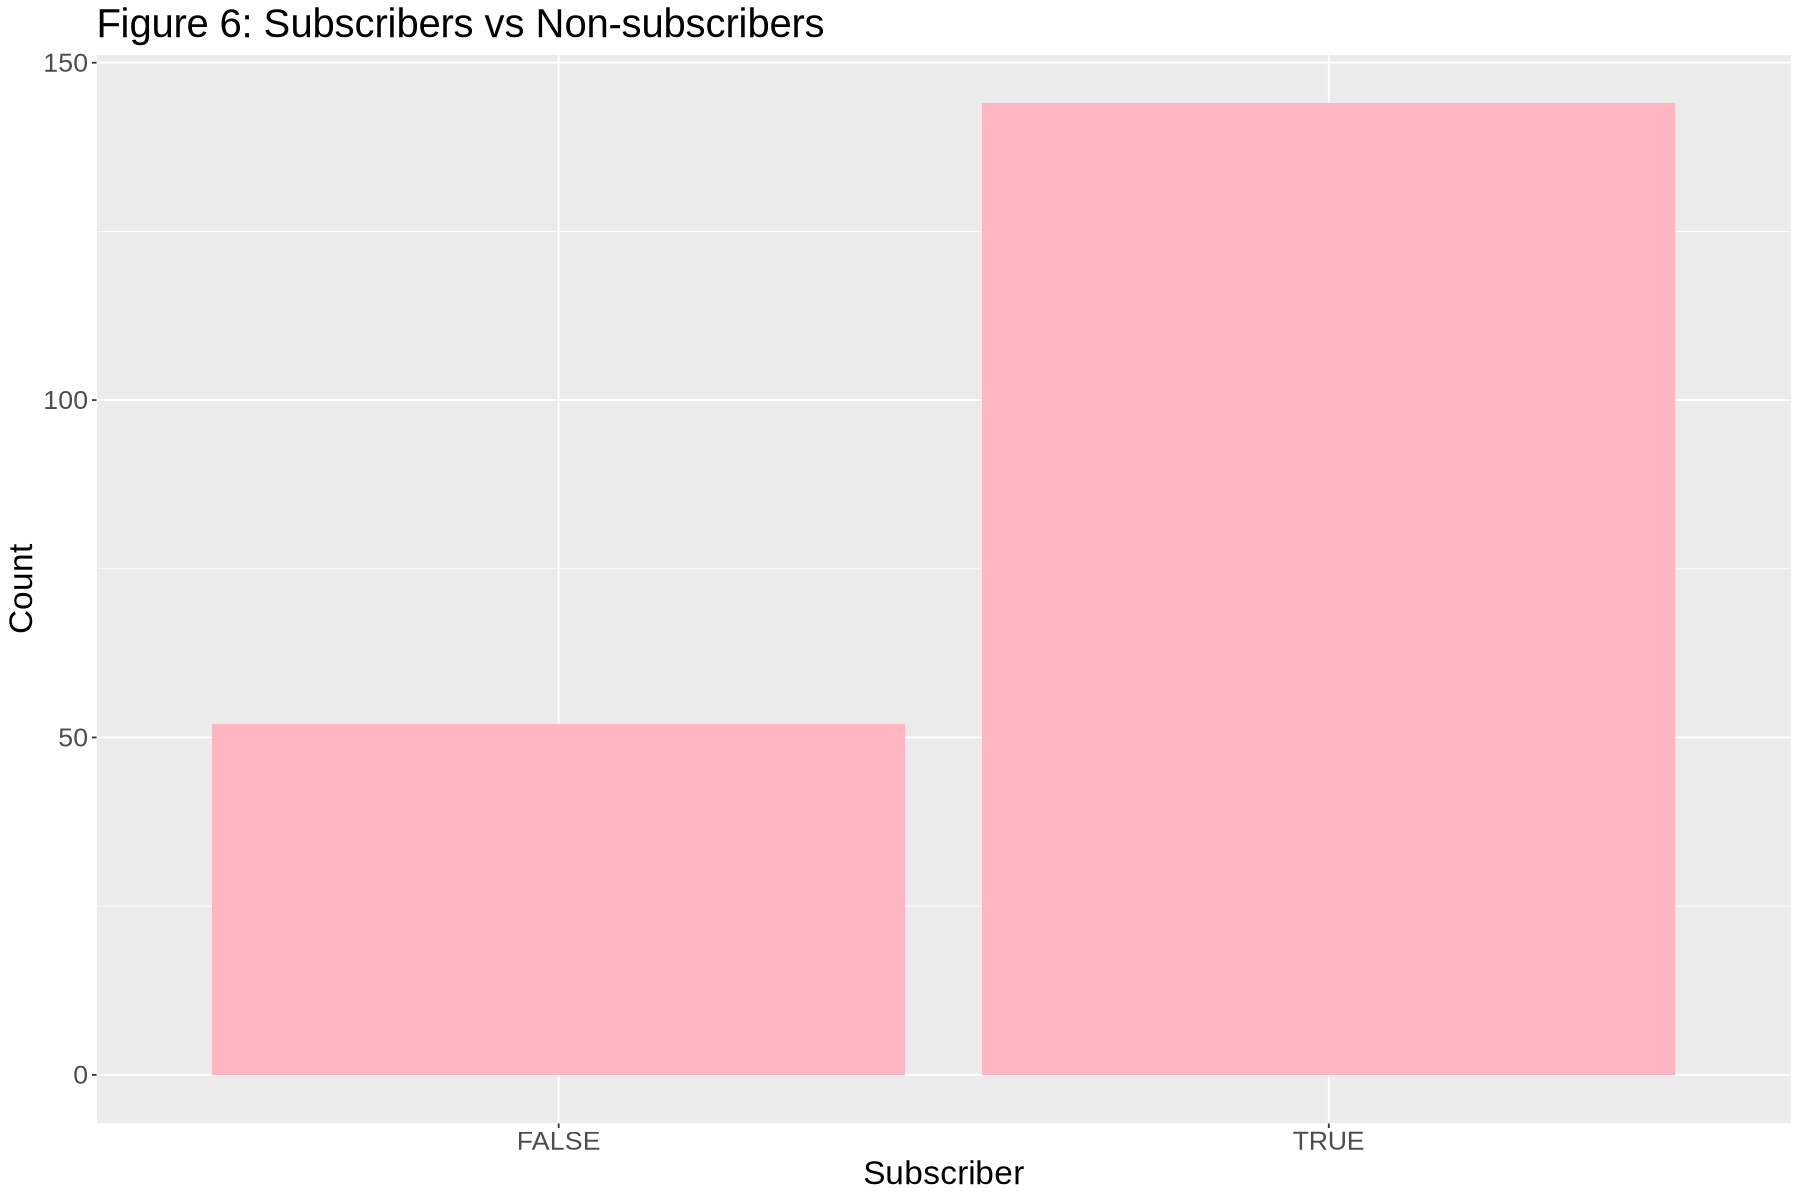

In [22]:
players_maj <- players |>
    ggplot(aes(x = subscribe)) + 
    geom_bar(fill = "lightpink") + 
    labs(title = "Figure 6: Subscribers vs Non-subscribers", 
         x = "Subscriber", 
         y = "Count") + 
theme(text = element_text(size = 20))

players_maj

Figure 6. As we can see, there are far **more subscribers** than **non-subscribers**, which would make the model **biased** toward the majority class. **Accuracy** becomes misleading, and the model struggles to correctly identify the minority class. If the model achieves high accuracy simply by predicting "subscribe" for everyone, the stakeholders may incorrectly believe that age and hours played strongly predict subscription. This can mislead them to trust a model that is not reliable, resulting in poor decision making. 

### Evaluation summar
The KNN model achieved 70% accuracy on the test set, with a precision and recall of 79% for predicting subscribers. Identifying actual subscribers is relatively good. In addition, class imbalance limits the performance of the model. The class means that the number of subscribers is more than the number of non-subcribers. Thus, our model provides some useful insight, but it cannot predict all. KNN model shows moderate performance, performing better at predicting subscribers and has some limitations, which need to more modified and achieve better performance.

### Discussion
**Findings**
- Our analysis shows that players' age and total hours played have a moderate relationship with subscribing to the newsletter in the game. Our KNN model achieved 70% accuracy on the test set and 79% precision and recall for predicting subscribers. The evaluation of this model is well, but our model has the limitations, like class imbalance. Overall, age and played hours provide some predictive insights, but they actually cannot perfectly predict the subscription.
  
**Whether this was expect**
- The result was performance well and as expected. We prefer to think that players who play more hours or specific age range will more likely to subscribe. However, these two features alone can not strongly determine the relationship between subscription.
  
**Impact**
- The finding provides useful insights for game developers and marketers. They can target players who have specific features, such as specific age range and specific range of played hours. In addition, the results of the model can be used for marketing strategies, game design optimization, or targeted in-game events.
  
**Future question**
- In the future, we can explore additional features and try other models to achieve  better prediction accuracy
  of newsletter subscription. 